## Behavior Cloning

Jun Zhu

In this project, a deep learning model which can drive the car automatially in a [simulator](https://github.com/udacity/self-driving-car-sim) was trained. There are three cameras (left, center and right) mounted in the car and they will take pictures when the car is running. The image data saw by the car were first fed into a convolutional neural network (CNN). After that, the well-trained model will be used to predict the steering angle of the car in the autonomous mode in the simulator to keep the car in the main road.

In [99]:
import tensorflow as tf
import keras

print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Tensorflow version: 1.0.1
Keras version: 2.0.3


# Data collecting and preprocessing

## Load the data

In [100]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


angle_correction = 0.1  # correction angle for left (+) and right (-) images

# Read the data log file
data_files = ["driving_log_1.csv", "driving_log_2.csv"]

drive_data = []
for data_file in data_files:
    new_data = pd.read_csv(
        "data/" + data_file, header=0,
        names=['center_image', 'left_image', 'right_image',
               'steering_angle', 'throttle', 'break', 'speed'])
    drive_data.append(new_data)

drive_data = pd.concat(drive_data)

In [101]:
## Visualize the data

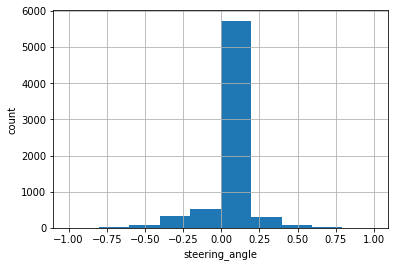

In [102]:
import matplotlib
%matplotlib inline

ax = drive_data['steering_angle'].hist()
ax.set_xlabel('steering_angle')
ax.set_ylabel('count')

It seems the steering angle is normalized between [-1, 1].

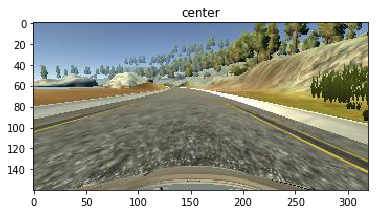

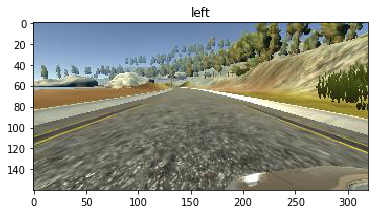

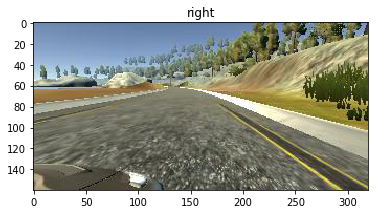

In [103]:
from scipy import misc, ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import random


# Visualize the central, left and right images in the same random position.
i = random.choice(range(len(drive_data)))
X = misc.imread(drive_data['center_image'].iloc[i].strip())
plt.imshow(X)
plt.title('center')
plt.show()

X_left = misc.imread(drive_data['left_image'].iloc[i].strip())
plt.imshow(X_left)
plt.title('left')
plt.show()

X_right = misc.imread(drive_data['right_image'].iloc[i].strip())
plt.imshow(X_right)
plt.title('right')
plt.show()

## Train/test split

In [104]:
# Only the file name and steering angle are required
drive_data_center = drive_data[['center_image', 'steering_angle']].as_matrix()

drive_data_left = drive_data[['left_image', 'steering_angle']].as_matrix()
drive_data_left[:, 1] += angle_correction

drive_data_right = drive_data[['right_image', 'steering_angle']].as_matrix()
drive_data_right[:, 1] -= angle_correction

drive_data = np.concatenate([drive_data_center, drive_data_left, drive_data_right])
X_drive_data = drive_data[:, 0]
y_drive_data = drive_data[:, 1]

X_train, X_vali, y_train, y_vali = \
    train_test_split(X_drive_data, y_drive_data, test_size=0.2)

print("Number of train data: {}, number of validation data: {}.".
      format(len(X_train), len(y_vali)))

Number of train data: 16963, number of validation data: 4241.


## Jitter the data

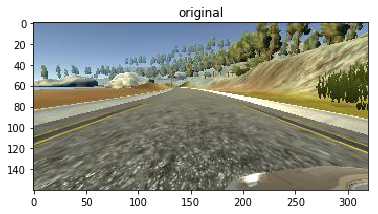

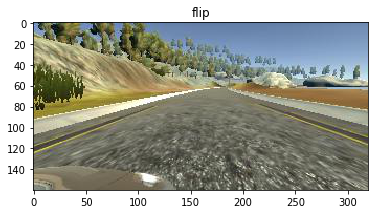

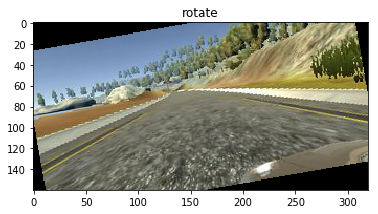

In [105]:
#original
plt.imshow(X_left)
plt.title('original')
plt.show()

#flip
X_jittered = np.fliplr(X_left)
plt.imshow(X_jittered)
plt.title('flip')
plt.show()

# rotation
X_jittered = ndimage.interpolation.rotate(X_left, 10, order=2, reshape=False)
plt.imshow(X_jittered)
plt.title('rotate')
plt.show()

# shift
# X_jittered = ndimage.interpolation.shift(X_jittered, [0, 0, 0], order=1)
# plt.imshow(X_jittered)
# plt.title('shift')
# plt.show()

# Brightness and contrast
# gain = 0.3  # Contrast is jittered between 1 +/- gain.
# bias = 50  # Bias is jittered between +/- bias.

# alpha = 1 + gain * (2 * random.random() - 1.0)
# beta = bias * (2 * random.random() - 1.0)
# X_jittered = alpha * X_jittered + beta
# X_jittered[X_jittered > 255] = 255
# X_jittered[X_jittered < 0] = 0
# plt.imshow(X_jittered.astype(np.uint8))
# plt.title('brightness and contrast')
# plt.show()

## Preprocessing

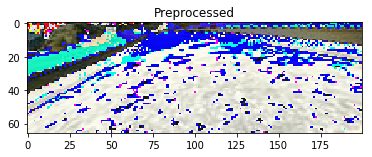

In [106]:
def preprocess(img):
    """Preprocessing an image

    Cropping, color space transformation and normalization.
    """
    img_ = img[60:126, 60:260]

    img_ = img_.astype(np.float)/255.0
    img_ -= 0.5
    assert abs(img_.max()) <= 1.0

    return img_


X_processed = preprocess(X_jittered)
plt.imshow(X_processed)
plt.title('Preprocessed')
plt.show()

# Neural network structure



The neural network structure is shown below. The following code shows the network structure published at https://arxiv.org/abs/1604.07316 ("End to end learning for self-driving cars").

In [107]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.initializers import random_normal, he_normal
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU


def set_model(params):
    """Set a Keras Sequential model.

    :param params: dictionary
        :key 'name': string
            Name of the network,
            - "None" for a simple testing network,
            - "NVIDIA" for the network published at https://arxiv.org/abs/1604.07316
            "End to end learning for self-driving cars".
        :key 'shape': tuple
            Shape of the input layer

    :return:
        Keras Sequential model.
    """
    cnn_network = Sequential()

    if params['name'] is None:
        cnn_network.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2),
                               kernel_initializer=he_normal(),
                               padding='same', input_shape=params['input_shape']))
        cnn_network.add(Activation('relu'))
        cnn_network.add(MaxPooling2D(pool_size=(2, 2)))

        cnn_network.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2),
                               kernel_initializer=he_normal(),
                               padding='same'))
        cnn_network.add(Activation('relu'))
        cnn_network.add(MaxPooling2D(pool_size=(2, 2)))

        cnn_network.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                               kernel_initializer=he_normal(),
                               padding='same'))
        cnn_network.add(Activation('relu'))
        cnn_network.add(MaxPooling2D(pool_size=(2, 2)))

        cnn_network.add(Flatten())

        cnn_network.add(Dropout(rate=0.5))

        cnn_network.add(Dense(100, kernel_initializer=he_normal()))
        cnn_network.add(Activation('relu'))

        cnn_network.add(Dropout(rate=0.5))

        cnn_network.add(Dense(10, kernel_initializer=he_normal()))
        cnn_network.add(Activation('relu'))

        # For regression problem
        cnn_network.add(Dense(1))
        cnn_network.summary()
    elif params['name'] == 'NVIDIA':
        cnn_network.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2),
                               kernel_initializer=he_normal(), padding='valid',
                               input_shape=params['input_shape']))
        cnn_network.add(Activation('relu'))

        cnn_network.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2),
                               kernel_initializer=he_normal(), padding='valid'))
        cnn_network.add(Activation('relu'))

        cnn_network.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2),
                               kernel_initializer=he_normal(), padding='valid'))
        cnn_network.add(Activation('relu'))

        cnn_network.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                               kernel_initializer=he_normal(), padding='valid'))
        cnn_network.add(Activation('relu'))

        cnn_network.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                               kernel_initializer=he_normal(), padding='valid'))
        cnn_network.add(Activation('relu'))

        cnn_network.add(Flatten())
        cnn_network.add(Dropout(rate=0.5))

        cnn_network.add(Dense(100, kernel_initializer=he_normal()))
        cnn_network.add(Activation('relu'))
        cnn_network.add(Dropout(rate=0.5))

        cnn_network.add(Dense(50, kernel_initializer=he_normal()))
        cnn_network.add(Activation('relu'))

        # For regression problem
        cnn_network.add(Dense(1))
    else:
        raise ValueError("Unknown model: {}".format(params['name']))

    return cnn_network


model_params = {
    'name': 'NVIDIA',
    'input_shape': (66, 200, 3)
}

cnn_network = set_model(model_params)
cnn_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
activation_3 (Activation)    (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
__________

# Model Training and testing

A generator was used to read and preprocess the data and then feed them into the network. Although the size of the data set is only about 600 MB, this pipeline can in principle be used to train a model with data of any size.

```
angle_correction = 0.13  # correction angle for left (+) and right (-) images


jitter_params = {
    'angle_jitter': 15,
    'angle_recover': 0.15,
    'shift_jitter': None,
    'shift_recover': 0.10,
    'gain': None,
    'bias': None
}


class BatchGenerator(object):
    def __init__(self, X, y, batch_size, preprocessor=None):
        """Initialize object.

        :param X: Nx2 numpy array.
            The first column is the path of the image file and the
            second column is the 'ref' indicator.
        :param y: float
            Label.
        :param batch_size: int
            Size of batch.
        :param preprocessor: None/object
            BatchPreprocessor instance.
        """
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.preprocessor = preprocessor

    def fit(self):
        """Generate batched data

        :return: features and labels.
        """
        n = len(self.y)
        while 1:
            X_shuffled, y_shuffled = shuffle(self.X, self.y)
            for i in range(0, n, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size].tolist()
                y_batch = y_shuffled[i:i+self.batch_size].tolist()

                for j in range(len(y_batch)):
                    X_batch[j], y_batch[j] = \
                        self.preprocessor.fit(X_batch[j], y_batch[j])

                yield (np.array(X_batch), np.array(y_batch))

```

The model was trained by tuning the following hyper-parameters:
```
angle_correction and jitter_params
```

To find the optimised hyper-parameters, the `angle_correction` was tuned first to find the minimum loss without any jitter. However, the car was not able to make a big turn with this model. Then the parameters in `jitter_params` were tuned to find the best model. In this case, whether the model is good or not can only be tested in the autonomous model. The loss at the end of training is only a reference. It can not tell you the validity of the model.  